In [1]:
#files needed to run the processing. NB utils is a package that Dane helped me make. It includes some important functions in it. 
import utils

import skimage
import napari
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw

from skimage import data, img_as_float, img_as_ubyte, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import tifffile as tif


### Load in the dry scan 

In [2]:
# Read the TIFF images
dirname = 'E:\\New reconstructions\\New reconstructions\\5_bentSample2_conf20bar_dry_binning2\\bottom\\reconstructed'
slices  = 10 #change this is you want to load in more slices NB python starts from 0 

dry_data = []

for i, fname in enumerate(os.listdir(dirname)):
    im = Image.open(os.path.join(dirname, fname))
    imarray = np.array(im)
    dry_data.append(imarray)
    if i >= slices:
        break

# convert to a 3D array and normalise so data is between 0 and 1 
dry_data  = np.asarray(dry_data) 
dry_data = utils.preprocess(dry_data, normalize_axis=0)

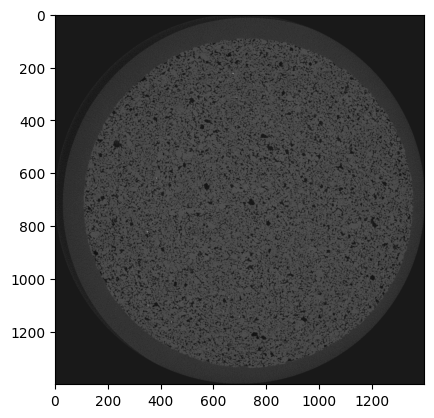

In [3]:
#view a slice
plt.imshow(dry_data[5, :, :], cmap="gray")

### Crop to a cylinder 

In [4]:
#NB this code can be edited to change the location and centre of the cylinder for the cropping 

def crop(img):
    z, h, w = img.shape
    
    # creating cylindrical mask
    lum_img = Image.new('L', [h, w], 0)
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(135, 90), (h-75, w-75)], 0, 360, fill=255)  #change values here to change the mask shape 
    mask = np.array(lum_img)
    mask = np.repeat(mask[np.newaxis, :, :], z, axis=0)
    mask = (mask == 0)

    assert img.shape == mask.shape
    assert mask.dtype == np.bool8

    foreground = img.copy()
    foreground[mask] = 255

    return foreground

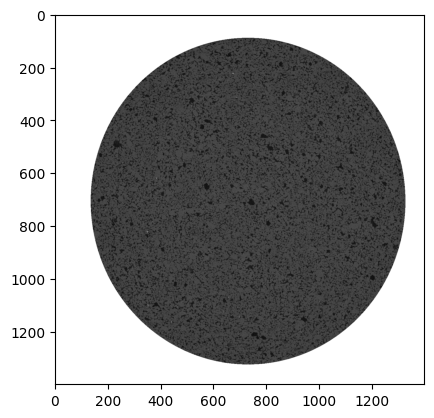

In [5]:
dry_data = crop(dry_data) #NB I overwrite things we don't need later on in the code because it saves memory. This can be changed. 
plt.imshow(dry_data[5, :, :], cmap="gray")


### Non-local means in 3D (currently the process that is the most computationally expensive)

In [6]:
#non-local means filter works better on float of image with no exposure or histogram modification.
dry_float = img_as_float(dry_data) 


# estimate the noise standard deviation from the noisy image
sigma     = 0.01 
noisy     = random_noise(dry_float, var=sigma**2)
sigma_est = np.mean(estimate_sigma(dry_float))
print(f'Calculated estimated noise standard deviation = {sigma_est}')
print(f'User given estimated noise standard deviation = {sigma}')


#these parameters control the neighbour used for smoothing. NB they have a large impact on run time especially patch_distance
patch_kw = dict(patch_size=2,        #  size of a patch 
                patch_distance=6)    #  search area
                

#other potential algorithms that were tested. The fast algorithm did a good job and runs much quicker. Best to use the value calculated from the image itself 
'''
# slow algorithm, sigma provided by user
denoise = denoise_nl_means(dry_float, h=1.5 * sigma, fast_mode=False,
                           **patch_kw)

# slow algorithm
denoise2 = denoise_nl_means(dry_float, h=1.5 * sigma_est, sigma=sigma_est,
                            fast_mode=False, **patch_kw)


# fast algorithm, sigma provided by user 
denoise_fast = denoise_nl_means(dry_float, h=1.5 * sigma, fast_mode=True,
                                **patch_kw)
'''

# fast algorithm
denoise2_fast = denoise_nl_means(dry_float, h=3 * sigma_est, sigma=sigma_est,
                                 fast_mode=True, **patch_kw)


Calculated estimated noise standard deviation = 0.0028869858536480016
User given estimated noise standard deviation = 0.01


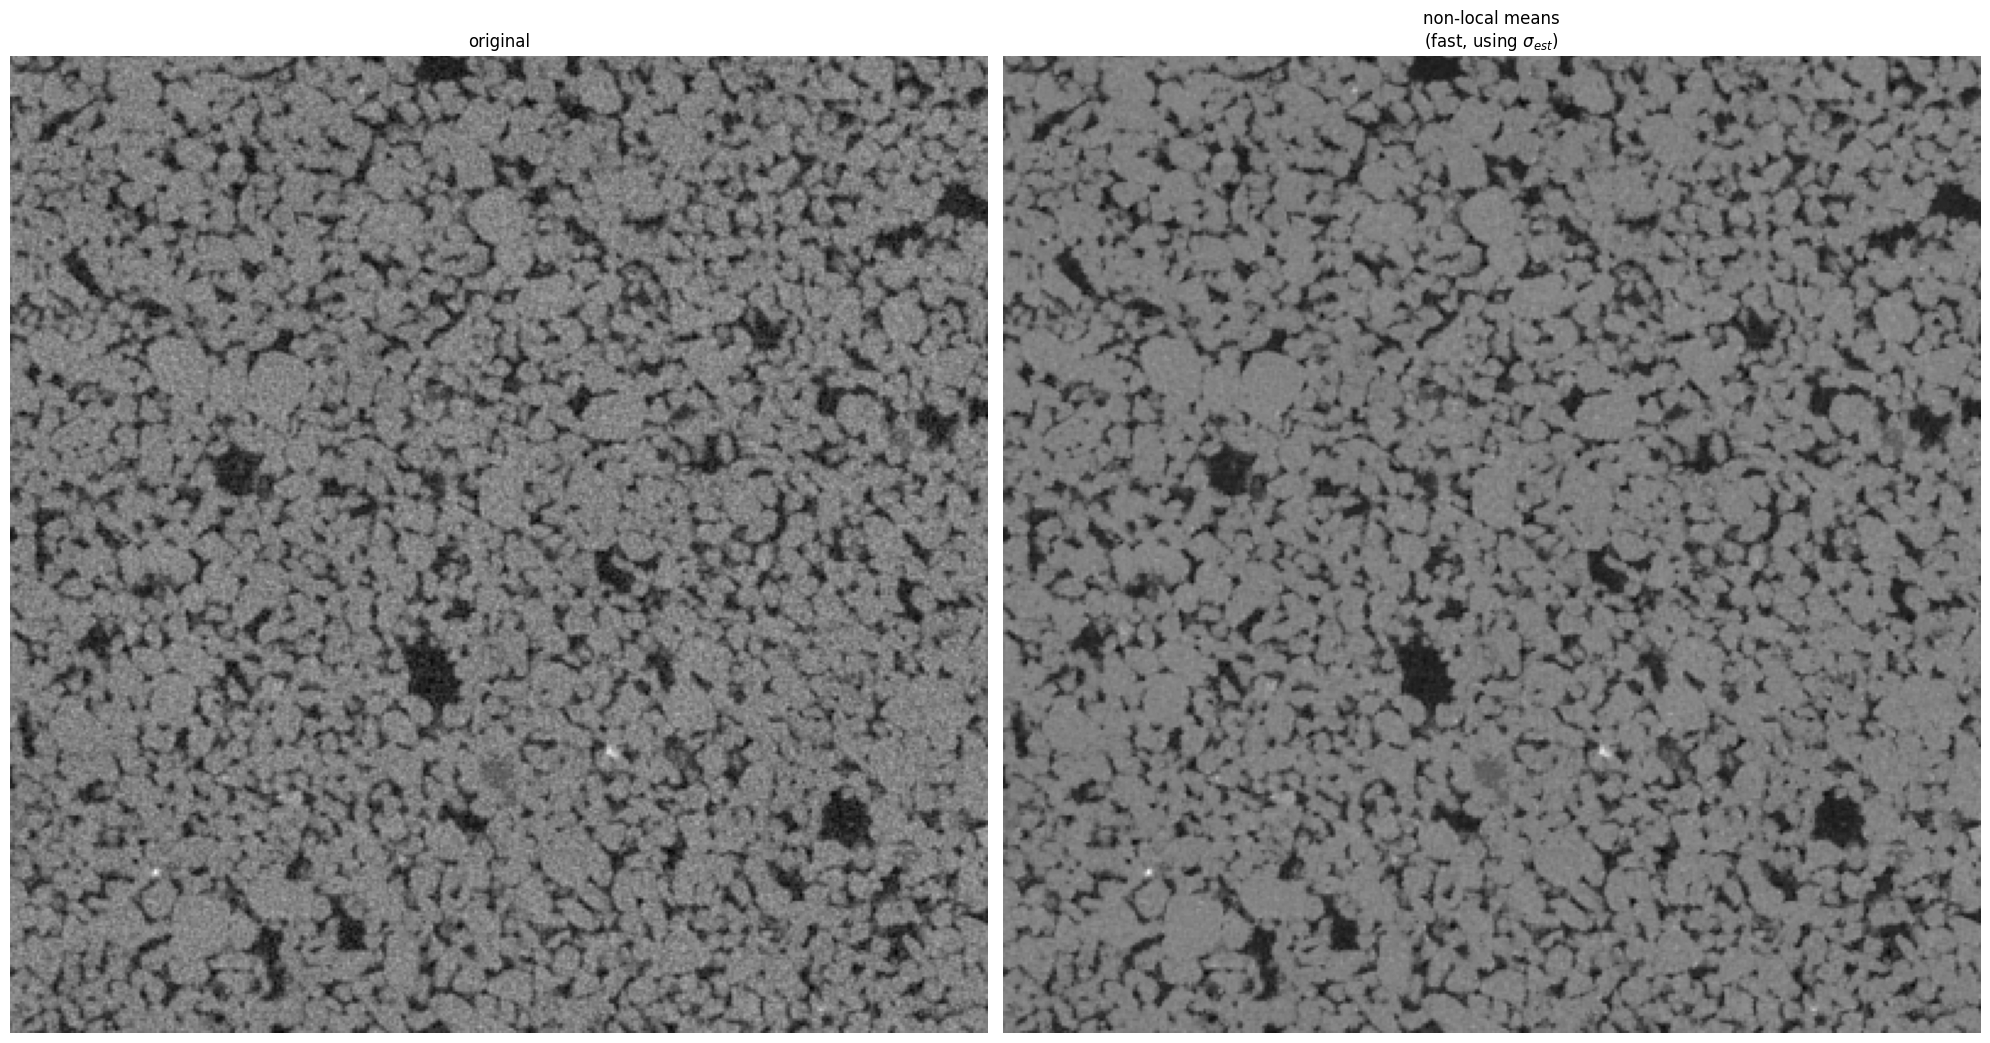

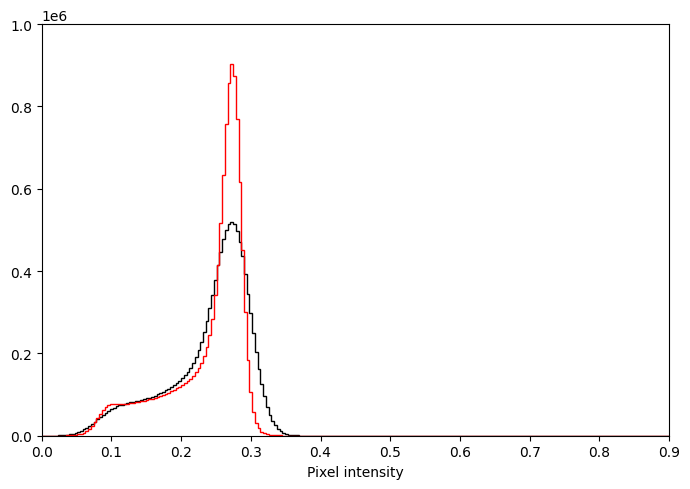

In [7]:
#check the filtering process 
#plot of filtered images (zoomed in for QC)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(dry_data[1, 400:800, 400:800],cmap='gray')
ax[0].axis('off')
ax[0].set_title('original')


ax[1].imshow(denoise2_fast[1,400:800, 400:800],cmap='gray')
ax[1].axis('off')
ax[1].set_title('non-local means\n(fast, using $\\sigma_{est}$)')

fig.tight_layout()
plt.show()

# can check the peak signal-to-noise ratio (PSNR) metric for each case if needed e.g. if you change the filtering parameters 
psnr_noisy = peak_signal_noise_ratio(dry_float, noisy)
psnr2_fast = peak_signal_noise_ratio(dry_float, denoise2_fast)


#print(f'PSNR (noisy) = {psnr_noisy:0.2f}')
#print(f'PSNR (fast, using sigma) = {psnr2_fast:0.2f}')


#plot of the histograms (entire image, not the zoomed in image)
bins=255
fig, ax = plt.subplots(figsize =(7, 5))
ax.set_xlabel('Pixel intensity')
ax.set_xlim(0, 0.9) #xlim must be <1 to ignore the mask 
ax.set_ylim(0, 10**6) 

ax.hist(dry_float.ravel(), bins=bins, histtype='step', color='black')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

ax.hist(denoise2_fast.ravel(), bins=bins, histtype='step', color='red')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

fig.tight_layout()
plt.show()

### Segmentation in 3D 

In [32]:


def simple_thresholding(img: np.array, min_threshold: float, max_threshold: float) -> np.array:
    return ((img.max() - img.min()) * min_threshold + img.min() <= img) & (img <= (img.max() - img.min()) * max_threshold + img.min())


def phase_segmentation_adapted_watershed(im, grain_thresh, pore_thresh):
    #initial 2D code stolen from Griffin Chure

    """
    Performs watershed segmentation on the greyscale image 
    
    Parameters
    ----------
    im : 3D array
        Image to be segmented. 
    
    grain_thresh: float
        Threshold below which grains exist. 
    pore_thresh: float 
        Threshold above which background exists. 
    
    Output
    -------
    final_seg: segmented image 
    """
    
    # Make sure that the input image is between 0 and 1 
    if np.max(im) != 1.0:
        im = (im - im.min()) / (im.max() - im.min())


    #plot histogram with limits of what is pore and what is grain shown
    fig, ax = plt.subplots(figsize =(10, 7))
    ax.set_ylim(0, 10**6) 
    ax.hist(im.ravel(), bins=bins, histtype='step', color='black')
    plt.axvline(grain_thresh, color='r', linestyle='dashed', linewidth=1)
    plt.axvline(pore_thresh, color='k', linestyle='dashed', linewidth=1)
    plt.show()

    
    # Make the image mask
    im_mask = np.array(im < grain_thresh)
    dilation_footprint = skimage.morphology.ball(10)
    im_mask_dilation = skimage.morphology.binary_dilation(im_mask, footprint=dilation_footprint)
    
    # Generate the catchment basins for watershed
    basins = np.zeros_like(im)
    basins[im < grain_thresh] = 2
    basins[im > pore_thresh] = 1

    # Peform the watershed by flooding. 
    flood_seg = skimage.segmentation.watershed(im , basins)
    flood_seg = flood_seg > 1.0
    
    # Now erode the boundaries and compute the distance transform. 
    footprint  = skimage.morphology.ball(3)
    flood_erode = skimage.morphology.binary_erosion(flood_seg, footprint=footprint)

    # Compute the distance matrix
    distances = ndi.distance_transform_edt(flood_seg)
    
    #Find the maxima
    local_max = skimage.feature.peak_local_max(
        distances, indices=False, footprint=None, labels=flood_seg)
    max_lab = skimage.measure.label(local_max)

    #Perform the topological watershed. 
    final_seg = skimage.segmentation.watershed(-distances, max_lab, mask=flood_seg)

    # Remove any stray crap. 
    final_seg = skimage.morphology.remove_small_objects(final_seg, min_size=3)

    #Normalise final_seg 
    final_seg = (final_seg - final_seg.min()) / (final_seg.max() - final_seg.min()) * 255

    # Subresolvable pores - large regions in the middle zone 
    sub_resolvable = simple_thresholding(im, grain_thresh, pore_thresh)
    sub_resolvable = skimage.morphology.remove_small_objects(sub_resolvable, min_size=4)   

    # display results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                         sharex=True, sharey=True) 
    ax = axes.ravel()
    ax[0].imshow(im[..., 2], cmap=plt.cm.gray)
    ax[1].imshow(im[..., 2], cmap=plt.cm.gray)
    ax[1].imshow(final_seg[..., 2], cmap=plt.cm.nipy_spectral, alpha=0.3)
    ax[1].imshow(sub_resolvable[..., 2], cmap=plt.cm.bone_r , alpha=0.5)
    plt.show()


    return np.array(final_seg, dtype=np.uint8), np.array(sub_resolvable, dtype=np.uint8)

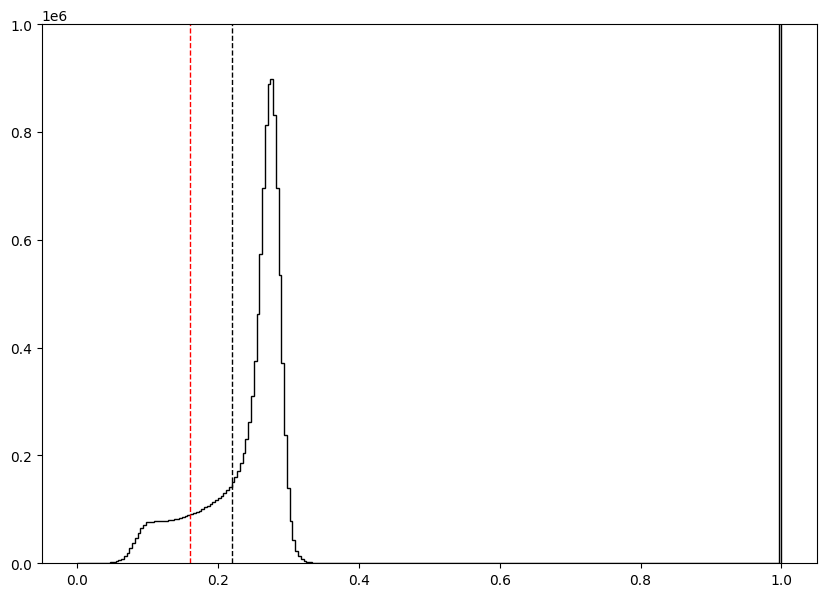

In [33]:
#perform the segmentation 
#potential to automate the values based on Gaussian curves for the pore space and grains 
input_segmentation                   = img_as_ubyte(denoise2_fast.transpose(1,2,0)) #must transpose the image for the input to be xyz, previously zxy
segmented_img, sub_resolved_pores    = phase_segmentation_adapted_watershed(input_segmentation, 0.16, 0.22)

#NB the histogram is normalised for the segmentation. Currently the mask values are included in this, so if you do a subvolume, then the threshold values need to change. 
#without the mask the values were 0.2 and 0.28 



In [ ]:
#convert to binary and check the segmentation 
#segmented_corrected = crop(segmented_img) #might need to recrop the cylinder 
segmented_binary             = np.where(segmented_img>0, 1, segmented_img).astype(np.bool8)
segmented_binary_subpore     = np.where(sub_resolved_pores>0, 1, sub_resolved_pores).astype(np.bool8)
greyscale_input              = (input_segmentation - input_segmentation.min()) / (input_segmentation.max() - input_segmentation.min()) * 255

seg_dry = utils.sanity_check(greyscale_input[3,...].astype(np.uint8), segmented_binary[...,3], 0.2)

fig, ax = plt.subplots(figsize =(10, 7))
plt.imshow(seg_dry)
plt.show()


(1400, 1400, 11)
(500, 500, 5)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1400 but corresponding boolean dimension is 500

### Save the image 

In [ ]:

#tif.imsave('segmented_test.tif', segmented_binary, bigtiff=True)
#tif.imsave('segmented_test.tif', sub_resolved_pores, bigtiff=True)
#could save sub-resolved separately, or in the same image 

AssertionError: 